# **PRÀCTICA 1: Identificació d'idioma**

# Main program

## Setup

In [1]:
import math
import json
from typing import Callable
from functions import *
import numpy as np

In [2]:
# Load trigrams and unique characters from json files
def dict_string_to_trigramtuple(d: dict) -> dict:
    return {key: {tuple(k): v for k, v in value.items()} for key, value in d.items()}

def refactor_validation(d: dict) -> dict:
    return {key: ({tuple(k2): v2 for k2, v2 in value[0].items()}, value[1]) for key, value in d.items()}

trigrams = dict_string_to_trigramtuple(json.load(open('./weights/trigrams.json')))
unique_chars = json.load(open('./weights/unique_chars.json'))

# Load preprocessed data (train and test)
train = json.load(open('./preprocessed_langId/train.json'))
test = json.load(open('./preprocessed_langId/test.json'))

validation_trigrams = refactor_validation(json.load(open('./weights/validation_trigrams.json')))
validation_unique = json.load(open('./weights/validation_unique_chars.json'))


In [3]:
# Dictionaries to optimize Lidstone smoothing calculation
b_value_dict = {key: value ** 3 for key, value in unique_chars.items()}
totals = {key: sum(trigrams[key].values()) for key in trigrams.keys()}

In [4]:
# Test the Lidstone smoothing
text = '  on a su en profiter  '
probs = []
languages = {"deu": "Deutsch (German)", 
             "eng": "English (English)", 
             "fra": "Français (French)", 
             "ita": "Italiano (Italian)", 
             "spa": "Español (Spanish)", 
             "nld": "Nederlands (Dutch)"}
total_trigrams = {key: sum(dicts.values()) for key, dicts in trigrams.items()}
for language in trigrams.keys():
    prob = probs_total(b_value=b_value_dict[language], text=text, model=trigrams[language], total_trigrams=total_trigrams[language], smooth=absolute_discounting, param=0.1,)
    probs.append((language, prob))
max_probs = max(probs, key = lambda x: x[1])
print(max_probs)
probs = sorted(probs, key = lambda x: x[1], reverse=True)

# Normalize the probabilities and print the results
exp = [math.exp(p[1] - max_probs[1]) for p in probs]
normalize = [(e / sum (exp))*100 for e in exp]
lang = [languages[p[0]] for p in probs]
for e in range(len(lang)):
    print(f"{lang[e]}: {normalize[e]}")

('fra', -166.19743069715162)
Français (French): 86.91023725963916
Español (Spanish): 12.770262403284294
English (English): 0.30295865945918454
Italiano (Italian): 0.015495148206571356
Deutsch (German): 0.0008407386526095491
Nederlands (Dutch): 0.00020579075819388392


## Validation

In [5]:
unique_trigrams = set()
for k in trigrams.keys():
    unique_trigrams.update(set(trigrams[k].keys()))

def create_prob_dict(b_value_dict: dict = b_value_dict, smooth: Callable = lidstone_smooth, param: float = 0.5, model: dict = trigrams, total: dict = totals, unique: set = unique_trigrams):
    d = {}
    for lang in languages.keys():
        probab = {tri: math.log(smooth(param, trigram=tri, b_value=b_value_dict[lang], trigram_counts=model[lang], total_trigrams=total[lang])) for tri in unique}
        d[lang] = probab
    return d

In [6]:
val_train = {key: value[0] for key, value in validation_trigrams.items()}
val_test = {key: value[1] for key, value in validation_trigrams.items()}

In [7]:
def accuracy_validation(smooth: Callable = lidstone_smooth, param: float = 0.5):
    validation_errors = []
    totals_val = {key: sum(val_train[key].values()) for key in val_train.keys()}
    probabilities = create_prob_dict(b_value_dict=b_value_dict, smooth=smooth, param=param, model=val_train, total=totals_val, unique=unique_trigrams)
    for lang in languages.keys():
        for sentence in val_test[lang]:
            probs = []
            for ling in languages.keys():
                prob = probs_total(model = val_train[ling], param=param, text=sentence, smooth=smooth, b_value=b_value_dict[ling], probabilities=probabilities[ling], total_trigrams=totals_val[ling])
                probs.append((ling, prob))
            max_prob = max(probs, key = lambda x: x[1])
            if max_prob[0] != lang:
                validation_errors.append({"text": sentence, "true": lang, "pred": max_prob[0]})
    return validation_errors

In [ ]:
smoothing_functions = [lidstone_smooth, linear_discounting, absolute_discounting]
alphas = [0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 1]

i = 0
for func in smoothing_functions:
    for alph in alphas:
        if alph == 1 and (func == linear_discounting or func == absolute_discounting):
            break
        print(f"Iteration {i}: alpha {alph}, smoothing {func.__name__}")
        err = accuracy_validation(func, alph)
        print(f"{len(err)} errors.")
        i += 1

## Test

Total errors: 104 out of 59977 sentences.
Total accuracy: 0.9982660019674209
*Accuracy deu: 0.9987987987987988
*Accuracy eng: 0.99969960949234
*Accuracy fra: 0.9985
*Accuracy ita: 0.9976
*Accuracy nld: 0.9962
*Accuracy spa: 0.9988


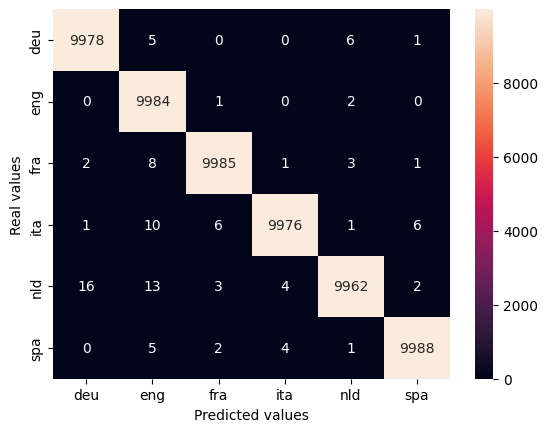

WRONG PREDICTIONS:
*True: deu, Predicted: spa, Text: "  autos wie den dacia sandero.  "
*True: deu, Predicted: nld, Text: "  bildergalerie teilen der donkervoort d gto ist ja per se nicht gerade ein warmduscherauto.  "
*True: deu, Predicted: eng, Text: "  darunter das restaurant mappamondo und der takeawaybetrieb the beef burger.  "
*True: deu, Predicted: nld, Text: "  der stoffbeutel war leer.  "
*True: deu, Predicted: nld, Text: "  die polizeiorganisation europol koordinierte die operation.  "
*True: deu, Predicted: eng, Text: "  erworben wird joey's von einem joint venture der britischen domino's pizza group dpg und der australischen domino's pizza enterprises dpe.  "
*True: deu, Predicted: nld, Text: "  hij was de leider van de groep in de provincie khorasan van de islamitische staat.  "
*True: deu, Predicted: eng, Text: "  jarjarthomas . jan theorethisch ist es simpel.  "
*True: deu, Predicted: nld, Text: "  mit dabei ist nikolaj costerwaldau.  "
*True: deu, Predicted: eng, Text: 

In [8]:
# Test
prediction_errors_list = []
predictions = {language: [] for language in test.keys()}

for language in test.keys():
	for sentence in test[language]:
		probs = []
		sentence = "  "+sentence+"  " # Add spaces to the beginning and end of the sentence for better results
		for lingua in trigrams.keys():
			prob = probs_total(model=trigrams[lingua], text=sentence, b_value=b_value_dict[lingua], smooth=absolute_discounting, param=0.2, total_trigrams=totals[lingua])
			probs.append((lingua, prob))
		max_prob = max(probs, key = lambda x: x[1])
		predictions[language].append(max_prob[0])
		if max_prob[0] != language:
			prediction_errors_list.append({"text": sentence, "true": language, "pred": max_prob[0]})

# Calculate accuracy
correct_predictions = {language: sum([1 for pred in predictions[language] if pred == language]) for language in test.keys()}
total_accuracy = sum(correct_predictions.values()) / sum([len(value) for value in test.values()])

# Print results
print(f"Total errors: {len(prediction_errors_list)} out of {sum([len(value) for value in test.values()])} sentences.")
print(f"Total accuracy: {total_accuracy}")
for language, correct in correct_predictions.items():
	print(f"*Accuracy {language}: {correct / len(test[language])}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

language_names = [language for language in test.keys()]

cm = confusion_matrix(y_true=[language for language in test.keys() for _ in range(len(test[language]))],
					  y_pred=[pred for language in test.keys() for pred in predictions[language]],
					  labels=language_names)

sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=language_names, yticklabels=language_names)
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.show()

# Print the errors
print("WRONG PREDICTIONS:")
for error in prediction_errors_list:
	print(f"*True: {error['true']}, Predicted: {error['pred']}, Text: \"{error['text']}\"")